# Set Up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
%matplotlib inline

train = pd.read_csv('./data/train.csv')
print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Examining the Data

In [2]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [3]:
# Collecting the 'object' columns
obj_cols = list(train.columns[train.dtypes=='object'])
obj_cols.remove('Loan_ID')
obj_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [4]:
# Showing unique values of each column with 'object' data types
# This will help determine how to preprocess them into number data types
for col in obj_cols:
    print(f"{col}:")
    print(f"{train[col].unique()}\n")

Gender:
['Male' 'Female' nan]

Married:
['No' 'Yes' nan]

Dependents:
['0' '1' '2' '3+' nan]

Education:
['Graduate' 'Not Graduate']

Self_Employed:
['No' 'Yes' nan]

Property_Area:
['Urban' 'Rural' 'Semiurban']

Loan_Status:
['Y' 'N']



# Preprocessing Data

In [5]:
ntrain = train.copy()

## Finding missing values

In [6]:
rows = train.shape[0]

for col in ntrain.columns:
    missing = ntrain[col].isnull().sum()
    if missing > 0:
        print(f"{col}: {(missing/rows)*100:.2f}%")
        print(f"{missing} missing values out of {rows}\n")

Gender: 2.12%
13 missing values out of 614

Married: 0.49%
3 missing values out of 614

Dependents: 2.44%
15 missing values out of 614

Self_Employed: 5.21%
32 missing values out of 614

LoanAmount: 3.58%
22 missing values out of 614

Loan_Amount_Term: 2.28%
14 missing values out of 614

Credit_History: 8.14%
50 missing values out of 614



Luckily, none of the columns above have significantly large amounts of missing data, so I will simply determine the missing values myself based on similar patterns. The first step that comes to mind is starting with the personal information data of the applicants, like gender, marriage status, number of dependents, employment type, and credit history.

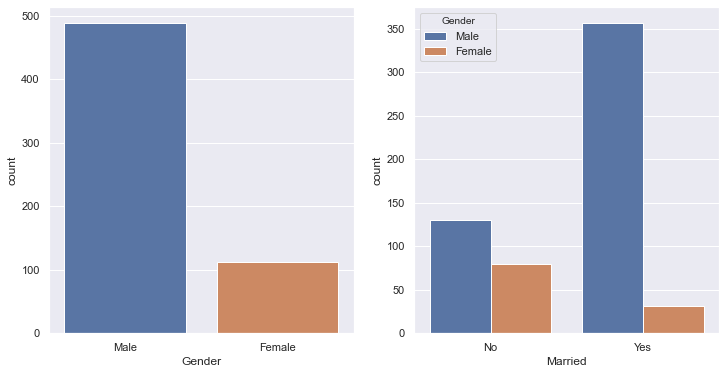

In [40]:
sns.set(rc={'figure.figsize': (12,6)})

# The 'Gender' column
subplot(1,2,1)
sns.countplot(data=ntrain, x='Gender')

# The 'Married' column
subplot(1,2,2)
sns.countplot(data=ntrain, x='Married', hue='Gender')

I want to see which factor affects the gender column most, and more specifically which aspect is most helpful in determining if an applicant is a female

In [64]:
females = ntrain[ntrain.Gender=='Female']
males = ntrain[ntrain.Gender=='Male']

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,112.000000,112.000000,109.000000,109.000000,101.000000
mean,4643.473214,1108.008929,126.697248,352.293578,0.831683
std,3585.381488,4094.595514,79.286460,56.722081,0.376013
min,210.000000,0.000000,9.000000,36.000000,0.000000
25%,2661.500000,0.000000,88.000000,360.000000,1.000000
50%,3583.000000,0.000000,113.000000,360.000000,1.000000
75%,4606.500000,1635.000000,138.000000,360.000000,1.000000
max,19484.000000,41667.000000,600.000000,480.000000,1.000000


### Marriage status and Income, by gender

In [111]:
print("Female applicants' Income, by their marriage status")
print(f"The average income for all female applicants is: {ntrain[ntrain.Gender=='Female'].ApplicantIncome.mean():.2f}")
income_by_marriage_female = pd.pivot_table(females, index='Married', values='ApplicantIncome')
income_by_marriage_female

Female applicants' Income, by their marriage status
The average income for all female applicants is: 4643.47


,ApplicantIncome
Married,
No,4503.787500
Yes,4829.645161


In [110]:
print("Male applicants' Income, by their marriage status")
print(f"The average income for all male applicants is: {ntrain[ntrain.Gender=='Male'].ApplicantIncome.mean():.2f}")
income_by_marriage_male = pd.pivot_table(males, index='Married', values='ApplicantIncome')
income_by_marriage_male

Male applicants' Income, by their marriage status
The average income for all male applicants is: 5446.46


,ApplicantIncome
Married,
No,5236.146154
Yes,5529.540616


In [99]:
print(f"Married female applicants earn {(income_by_marriage_female.iloc[1][0]/income_by_marriage_female.iloc[0][0])*100:.2f}% more than their unmarried counterparts")
print(f"Married male applicants earn {(income_by_marriage_male.iloc[1][0]/income_by_marriage_male.iloc[0][0])*100:.2f}% more than their unmarried counterparts")

Married female applicants earn 107.24% more than their unmarried counterparts
Married male applicants earn 105.60% more than their unmarried counterparts


In [122]:
pd.pivot_table(females, index=['Married','Education'], values=['ApplicantIncome', 'CoapplicantIncome'])

ApplicantIncome  CoapplicantIncome
Married Education                                       
No      Graduate          4337.196970        1200.545455
        Not Graduate      5289.142857         168.928571
Yes     Graduate          5246.920000        1361.400000
        Not Graduate      3091.000000        1410.166667

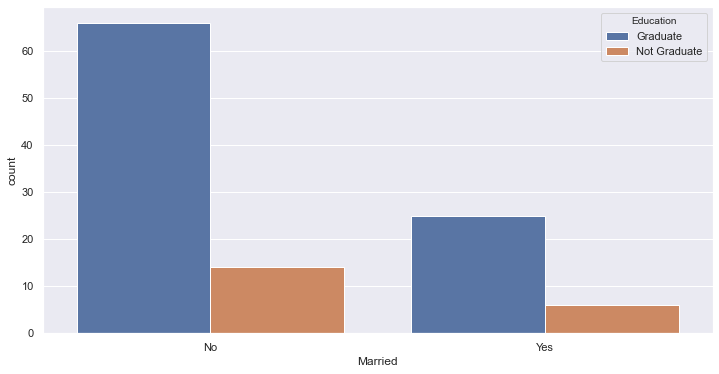

In [124]:
sns.countplot(data=females, x='Married', hue='Education')

In [66]:
males.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,489.000000,489.000000,470.000000,478.000000,451.000000
mean,5446.460123,1742.932352,149.265957,339.665272,0.847007
std,6185.789262,2606.507054,82.810851,67.089140,0.360381
min,150.000000,0.000000,17.000000,12.000000,0.000000
25%,2917.000000,0.000000,104.000000,360.000000,1.000000
50%,3865.000000,1430.000000,130.000000,360.000000,1.000000
75%,5923.000000,2436.000000,175.000000,360.000000,1.000000
max,81000.000000,33837.000000,650.000000,480.000000,1.000000


In [62]:
# How does the level of education affect an applicant's Income bracket 
# (as well as the income bracket of their coapplicant)
print(pd.pivot_table(ntrain, index='Education', values='ApplicantIncome'))
print('\n')
print(pd.pivot_table(ntrain, index='Education', values='CoapplicantIncome'))

              ApplicantIncome
Education                    
Graduate          5857.433333
Not Graduate      3777.283582


              CoapplicantIncome
Education                      
Graduate            1717.474833
Not Graduate        1276.544776


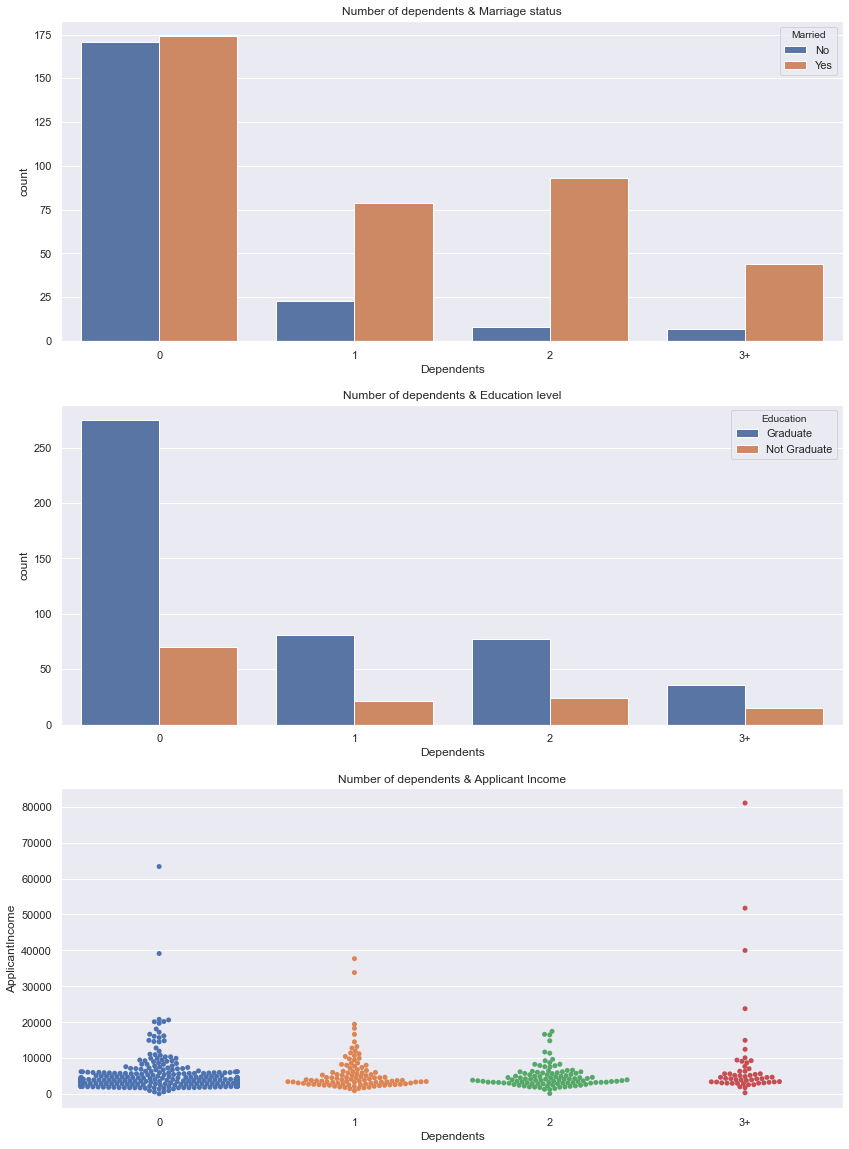

In [19]:
# The 'Dependents' column
sns.set(rc={'figure.figsize': (14,20)})

subplot(3,1,1)
plt.title("Number of dependents & Marriage status")
f1 = sns.countplot(data=ntrain, x='Dependents', hue='Married')

subplot(3,1,2)
plt.title("Number of dependents & Education level")
f2 = sns.countplot(data=ntrain, x='Dependents', hue='Education')

subplot(3,1,3)
plt.title("Number of dependents & Applicant Income")
f3 = sns.swarmplot(data=ntrain, x='Dependents', y='ApplicantIncome')

plt.show()

In [ ]:
# The 'Self_Employed' column

In [ ]:
# The 'LoanAmount' and 'Loan_Amount_Term' columns

In [ ]:
# The 'Credit_History' column

Some immediate findings can be that regardless of marriage status or education level of the applicant, the chances of them having any dependents is relatively very small. So to me this seems like a safe indicator that it would be okay to replace all null values of 'Dependents' of unmarried applicants to 0.

In [20]:
ntrain.loc[ntrain.Dependents.isnull(), 'Dependents'] = '0'
ntrain[ntrain.Dependents.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


In [ ]:
# Creating a copy of the original dataset
ntrain = train.copy()

# Binary Encoding the following columns:
# (Generally 0 means 'no' or implies negation, while 1 the opposite)

# Gender
ntrain.loc[ntrain.Gender == 'Male', 'Gender_encoded'] = 0
ntrain.loc[ntrain.Gender == 'Female', 'Gender_encoded'] = 1
print(ntrain.shape)

# Married
ntrain.loc[ntrain.Married == 'No', 'is_married'] = 0
ntrain.loc[ntrain.Married == 'Yes', 'is_married'] = 1
print(ntrain.shape)

# Married
ntrain.loc[ntrain.Education == 'No', 'is_graduate'] = 0
ntrain.loc[ntrain.Education == 'Yes', 'is_graduate'] = 1
print(ntrain.shape)

# Self_Employed
ntrain.loc[ntrain.Self_Employed == 'No', 'is_self_employed'] = 0
ntrain.loc[ntrain.Self_Employed == 'Yes', 'is_self_employed'] = 1
print(ntrain.shape)

# Loan_Status
ntrain.loc[ntrain.Loan_Status == 'N', 'loan_approved'] = 0
ntrain.loc[ntrain.Loan_Status == 'Y', 'loan_approved'] = 1
print(ntrain.shape)

ntrain.head()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()

# Creat a new column called 'has_child'
ntrain.loc[ntrain.Dependents=='0', 'has_child'] = 0
ntrain.loc[ntrain.has_child.isnull(), 'has_child'] = 1

# Dependents
ntrain.Dependents = ntrain.Dependents.astype(str)
results = binarizer.fit_transform(ntrain["Dependents"])
dependents_encoded = pd.DataFrame(results, columns=['0','1','2','3','nan'])

# Property_Area
results = binarizer.fit_transform(ntrain["Property_Area"])
property_area_encoded = pd.DataFrame(results, columns=binarizer.classes_)

ntrain = pd.concat([ntrain, education_encoded, property_area_encoded, dependents_encoded], axis=1, sort=False)
ntrain.drop('Property_Area', axis=1, inplace=True)
ntrain.drop('Dependents', axis=1, inplace=True)

ntrain.head()

# Finding correlation between columns

In [ ]:
train.head()

In [ ]:
sns.

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(data=train, x='Married', hue='Gender')

In [ ]:
train[train.Gender.isnull()]

In [ ]:
sns.countplot(data=train, x='Self_Employed', hue='Gender')

In [ ]:
sns.pairplot(train, hue='Gender', height=2.5)

# Preprocessing Data (2)